<a href="https://colab.research.google.com/github/gbiamgaurav/LLM-Chronicles/blob/main/llm_chronicles_3_2_gradient_descent_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autograd and Pytorch

Autograd is PyTorch's automatic differentiation engine. It powers neural network training by computing gradients for complex operations. With Autograd, tensors can remember where they come from in terms of operations and other tensors, making it possible to automatically compute gradients for backward passes.

**PyTorch documentation for Autograd**:
https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html


In [ ]:
!pip install torchviz
!pip install torchview

import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torchviz import make_dot

In [ ]:
x1 = torch.tensor([1.2])
x1

tensor([1.2000])

In [ ]:
x1.requires_grad

False

In [ ]:
w1 = torch.tensor([3.0], requires_grad=True)
w1

tensor([3.], requires_grad=True)

In [ ]:
o = x1 * w1
o

tensor([3.6000], grad_fn=<MulBackward0>)

In [ ]:
x1.grad, w1.grad

(None, None)

# The backward() Function

When you call the backward() function on a tensor (typically the loss), PyTorch computes the gradients for all tensors involved in the computation of that tensor, provided they have requires_grad set to True. These gradients are stored in the .grad attribute of the respective tensors.


In [ ]:
o.backward(retain_graph=True)

In [ ]:
x1.grad, w1.grad

(None, tensor([1.2000]))

## Quick derivate detour

You can skip this section, but if you're curious to see how the derivate is calcualted by hand, this is what's happening (https://en.wikipedia.org/wiki/Differentiation_rules):

$ \Large o(w_1) = x_1 \cdot w_1$

Product rule for derivation, $u = w_1, v=x_1$:

$\Large \frac{dy}{dx} = u \cdot \frac{dv}{dx} + v \cdot \frac{du}{dx} $

Applying the product rule:

$\Large \frac{do}{dw_1} = w_1 \cdot 0 + x_1 \cdot 1 = x_1 $

# Autograd and the Computation Graph

Autograd builds a computation graph as you perform operations on tensors. Each node in this graph represents a tensor, and the edges represent the operations that produce new tensors. When computing gradients, Autograd traverses this graph from the output (e.g., loss) back to the input tensors, applying the chain rule of differentiation. This backward traversal allows it to compute the gradient of the loss with respect to each tensor in the graph efficiently.


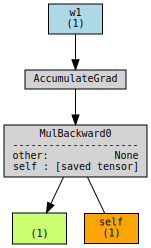

In [ ]:
make_dot(o, params={'w1': w1},  show_attrs=True, show_saved=True)

## A computation graph for a perceptron

Let's now look at a computation graph for a simple perceptron with two inputs and 1 output:

![picture](https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/3.2%20-%20Lab%20-%20Gradient%20Descent%20in%20Practice%20with%20PyTorch/backward-pass.png)

In [ ]:
x1 = torch.tensor([-1.1])
x2 = torch.tensor([2.4])

w1 = torch.tensor([0.6], requires_grad=True)
w2 = torch.tensor([1.3], requires_grad=True)
b = torch.tensor([0.2], requires_grad=True)

z = (x1*w1 + x2*w2) + b
# using ReLU instead of tanh for simplicity
y_hat = torch.nn.functional.relu(z)
y_hat

tensor([2.6600], grad_fn=<ReluBackward0>)

In [ ]:
y = torch.tensor(0.5)
l = y_hat - y
l

tensor([2.1600], grad_fn=<SubBackward0>)

In [ ]:
l.backward(retain_graph=True)

In [ ]:
w1.grad, w2.grad, b.grad

(tensor([-1.1000]), tensor([2.4000]), tensor([1.]))

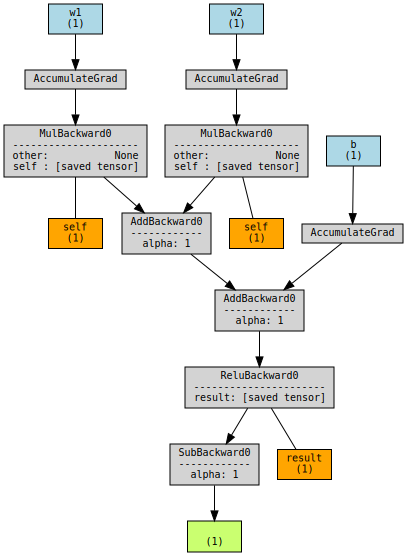

In [ ]:
make_dot(l, params={'w1': w1, 'w2': w2, 'b' : b},  show_attrs=True, show_saved=True)

## Understanding Derivatives

A derivative, in the context of neural network training, represents the sensitivity of the loss with respect to a particular parameter. In simpler terms, it tells us how much the loss would change if we made a tiny adjustment to that parameter. If the derivative is large, it means that parameter has a significant influence on the loss.

![picture](https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/3.2%20-%20Lab%20-%20Gradient%20Descent%20in%20Practice%20with%20PyTorch/gradient-descent.png)

In [ ]:
x1 = torch.tensor([-1.1])
x2 = torch.tensor([2.4])

w1 = torch.tensor([0.6+0.2], requires_grad=True)
w2 = torch.tensor([1.3-0.1], requires_grad=True)
b = torch.tensor([0.2-0.1], requires_grad=True)

z = (x1*w1 + x2*w2) + b
y_hat = torch.nn.functional.relu(z)
y = torch.tensor(0.5)
l = y_hat - y
l

tensor([1.6000], grad_fn=<SubBackward0>)

## A computation graph for out MNIST MLP

Let's now consider the simple Multi-Layer Perceptron (MLP) that we've built to recognize MNIST digits. This MLP consists of an input layer, hidden layers, and an output layer.

The only difference here is that we're multupying matrices instead of scalar values, but all the concepts we've seen are the same.



In [ ]:
class MNISTNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.Layer1 = nn.Linear(28*28, 100)
    self.Layer2 = nn.Linear(100, 150)
    self.Layer3 = nn.Linear(150, 10)

  def forward(self, x):
    x =  F.relu(self.Layer1(x))
    x =  F.relu(self.Layer2(x))
    x =  self.Layer3(x)
    return x

In [ ]:
# making up a random 28x28 image
x = torch.rand(1, 28*28)

model = MNISTNet()

In [ ]:
# forward pass
y_hat = model(x)
y_hat

tensor([[ 0.0268, -0.0930, -0.0011, -0.0296,  0.0743, -0.0373,  0.0677,  0.0393,
         -0.1071,  0.0185]], grad_fn=<AddmmBackward0>)

## Cross-Entropy Loss

Cross-entropy loss is a metric that quantifies the difference between two probability distributions. In the context of neural networks, it's commonly used to measure the dissimilarity between the predicted probability distribution (outputted by the model) and the true distribution.

For classification tasks, the true distribution is typically a one-hot encoded vector, where one class is marked as "certain" (with a value of 1) and all other classes as "impossible" (with values of 0). The model's predictions, often referred to as **logits**, represent the raw scores for each class.

![picture](https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/3.2%20-%20Lab%20-%20Gradient%20Descent%20in%20Practice%20with%20PyTorch/cross-entropy.png)


In [ ]:
# Making up a one-hot encoded target label
y = torch.tensor([[0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]])

loss = F.cross_entropy(y_hat, y)
loss

tensor(2.3932, grad_fn=<DivBackward1>)

In [ ]:
loss.backward(retain_graph=True)

In [ ]:
for name, param in model.named_parameters():
    print(name, param.grad)

Layer1.weight tensor([[-5.4157e-03, -2.5897e-02, -2.8696e-02,  ..., -3.8408e-04,
         -1.6741e-02, -3.5980e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-2.2655e-05, -1.0833e-04, -1.2004e-04,  ..., -1.6067e-06,
         -7.0029e-05, -1.5051e-04]])
Layer1.bias tensor([-5.1001e-02,  0.0000e+00,  0.0000e+00,  4.2626e-03,  0.0000e+00,
         4.6852e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  3.7230e-03,  9.8631e-04,  8.5146e-05,  5.2007e-03,
         0.0000e+00,  0.0000e+00,  6.4967e-03, -1.4560e-02,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00, -1.

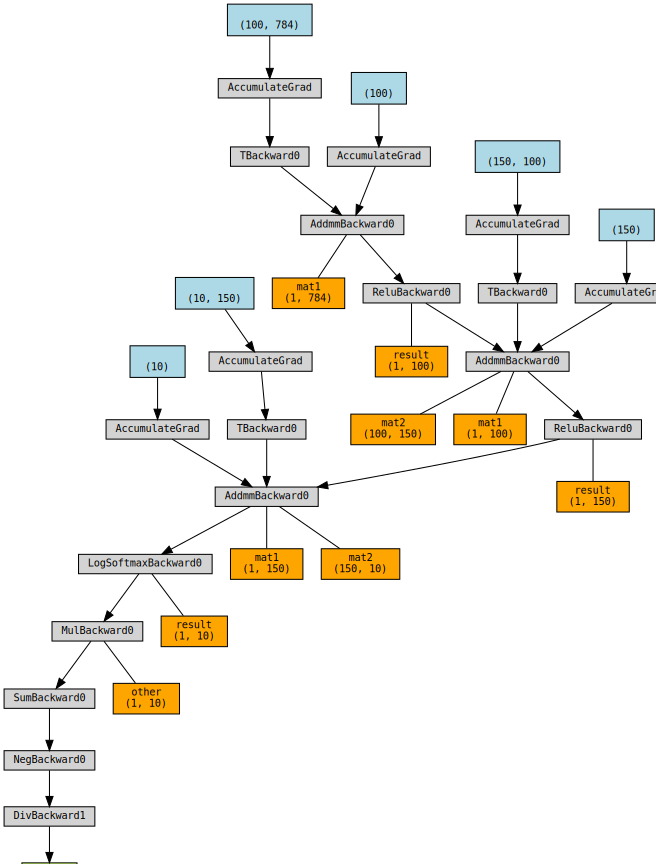

In [ ]:
make_dot(loss, show_attrs=False, show_saved=True)

# (Bonus) Visualize the Forward Pass

To end this, we're going to use torchview to visualize the forward pass of the MNIST MLP we built. This is not a computatin graph, but it's related as it gives us a visual representation of all the computations involved.

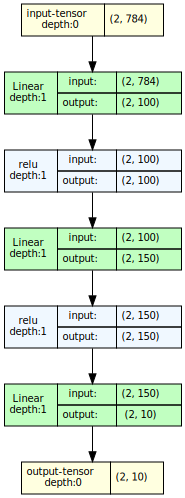

In [ ]:
from torchview import draw_graph
batch_size=2
model_graph = draw_graph(model, input_size=(batch_size, 28*28), device='meta')
model_graph.visual_graph